Author: Nelson Liu

Email: [nliu@uncharted.software](mailto:nliu@uncharted.software)

# Multi-Stratify Experiment

Construct a `n`-stratified model in Petri-net representation using AlgebraicJulia, following the code developed during the January 2023 DARPA-ASKEM Hackathon.

Source: [https://github.com/DARPA-ASKEM/program-milestones/blob/main/6-month-milestone/evaluation/scenario_1/ta_2/scenario1_stratify_v3.ipynb](https://github.com/DARPA-ASKEM/program-milestones/blob/main/6-month-milestone/evaluation/scenario_1/ta_2/scenario1_stratify_v3.ipynb)

In [1]:
# Libraries
using AlgebraicPetri, AlgebraicPetri.TypedPetri
using Catlab.Programs, Catlab.Graphics
using Catlab.CategoricalAlgebra
using GraphViz

## Define Ontology

`infect` interaction: two `Pop` converts into another two `Pop` (e.g. infection of one agent by another agent)

`disease` interaction: one `Pop` converts to another `Pop` (e.g. recovery from infection)

`strata` interaction: one `Pop` converts to another `Pop` (e.g. unvaccinated to vaccinated)

In [2]:
const infectious_ontology = LabelledPetriNet(
    [:Pop],
    :infect => ((:Pop, :Pop) => (:Pop, :Pop)),
    :disease => (:Pop => :Pop),
    :strata => (:Pop => :Pop)
)

#Graph(infectious_ontology)
to_graphviz(infectious_ontology)

LoadError: MethodError: no method matching to_graphviz(::LabelledPetriNet)
[0mClosest candidates are:
[0m  to_graphviz([91m::Catlab.WiringDiagrams.DirectedWiringDiagrams.WiringDiagram[39m; graph_name, orientation, node_labels, labels, label_attr, port_size, junction_size, outer_ports, anchor_outer_ports, graph_attrs, node_attrs, title, node_colors, edge_attrs, cell_attrs) at ~/.julia/packages/Catlab/87RDU/src/graphics/GraphvizWiringDiagrams.jl:81
[0m  to_graphviz([91m::Subobject{<:Catlab.Graphs.BasicGraphs.HasGraph}[39m; kw...) at ~/.julia/packages/Catlab/87RDU/src/graphics/GraphvizGraphs.jl:316
[0m  to_graphviz([91m::Catlab.WiringDiagrams.UndirectedWiringDiagrams.AbstractUWD[39m; kw...) at ~/.julia/packages/Catlab/87RDU/src/graphics/GraphvizWiringDiagrams.jl:408
[0m  ...

## Define Disease Model

Basic SIR disease model:
* `infect` interaction (infection of S by I)
* `disease` interaction (recovery of I to R)

Steps:
1. Start as an undirected wiring diagram (UWD)
2. Apply typing from the ontology
3. Define transition parameter names (`beta`, `gamma`)

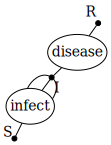

In [3]:
sir_uwd = @relation () where (S::Pop, I::Pop, R::Pop) begin
    infect(S, I, I, I)
    disease(I, R)
end

to_graphviz(sir_uwd, box_labels = :name, junction_labels = :variable)

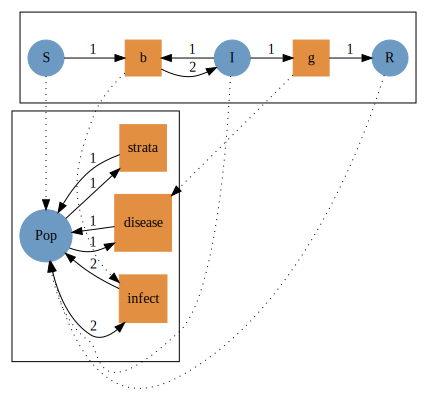

In [24]:
tnames = [:b, :g]
typed_sir = oapply_typed(infectious_ontology, sir_uwd, tnames)
Graph(typed_sir)

## Define Age-Group Contact Model

`N` age groups

Assume a contact model that is a fully connected pairwise graph with identity; 
i.e. every age group `:Pop` can infect every other age group `:Pop`, including self.

Note: the definition of `pairwise_id_typed_petri` is in [https://github.com/AlgebraicJulia/AlgebraicPetri.jl/blob/master/src/TypedPetri.jl](https://github.com/AlgebraicJulia/AlgebraicPetri.jl/blob/master/src/TypedPetri.jl)

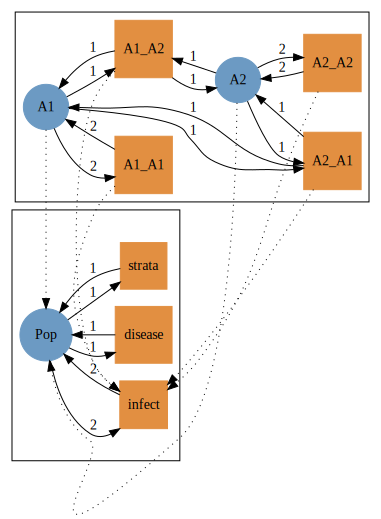

In [25]:
N = 2
snames = [Symbol("A$i") for i in 1:N]

typed_age = pairwise_id_typed_petri(infectious_ontology, :Pop, :infect, snames)

Graph(typed_age)

In [26]:
# Save to file
write_json_acset(dom(typed_age), "model_petri_age.json")

383

## Do Stratification as Petri Net Product

Stratification ~ product of two Petri-net models

Before applying the stratification operation, it is necessary to augment the base Petri nets with reflexives (self-to-self transitions)

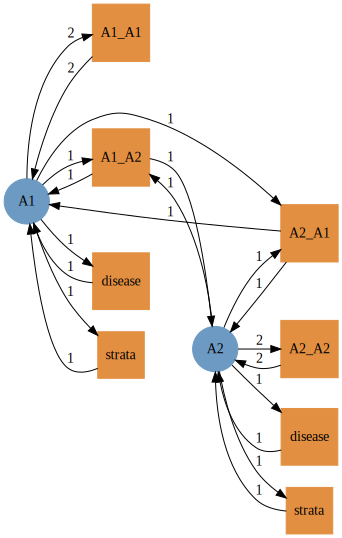

In [27]:
typed_age_aug = add_reflexives(
    typed_age,
    repeat([[:disease, :strata]], N),
    infectious_ontology
)

Graph(dom(typed_age_aug))

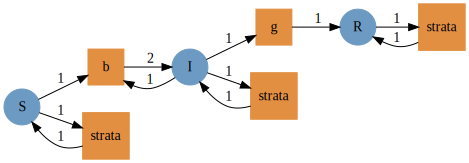

In [46]:
typed_sir_aug = add_reflexives(
    typed_sir,
    [[:strata], [:strata], [:strata]],
    infectious_ontology
)

Graph(dom(typed_sir_aug))

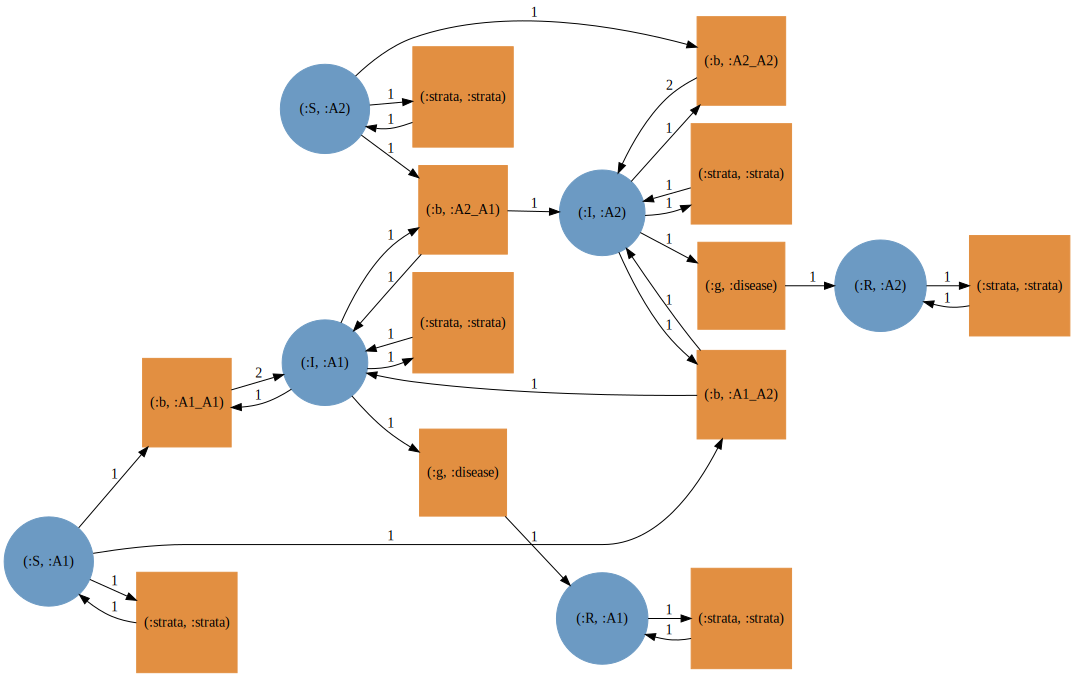

In [47]:
typed_sir_age = typed_product(typed_sir_aug, typed_age_aug)

Graph(dom(typed_sir_age))

In [48]:
# Save to file
write_json_acset(dom(typed_sir_age), "model_petri_sir-age.json")

997

## Repeat to Stratify International Travel Model

International travel ~ fully connected pairwise graph *without* identity since `:Pop` who do not travel just stay put.

Assume `M` countries

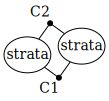

In [49]:
M = 2
snames = [Symbol("C$i") for i in 1:M]

# Need a function like `pairwise_id_typed_petri` but without identity
travel_uwd = @relation () where (C1::Pop, C2::Pop) begin
    strata(C1, C2)
    strata(C2, C1)
end

to_graphviz(travel_uwd, box_labels = :name, junction_labels = :variable)

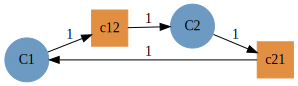

In [50]:
typed_travel = oapply_typed(infectious_ontology, travel_uwd, [:c12, :c21])

Graph(dom(typed_travel))

In [51]:
# Save to file
write_json_acset(dom(typed_travel), "model_petri_travel.json")

151

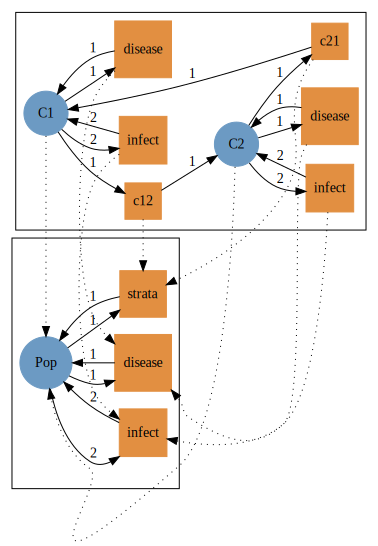

In [52]:
# Augment the travel model with reflexives

typed_travel_aug = add_reflexives(
    typed_travel,
    repeat([[:infect, :disease]], M),
    infectious_ontology
)

Graph((typed_travel_aug))

In [54]:
# No reflexive to add to SIR-Age model since they needed to be added before the (SIR x Age) stratification step

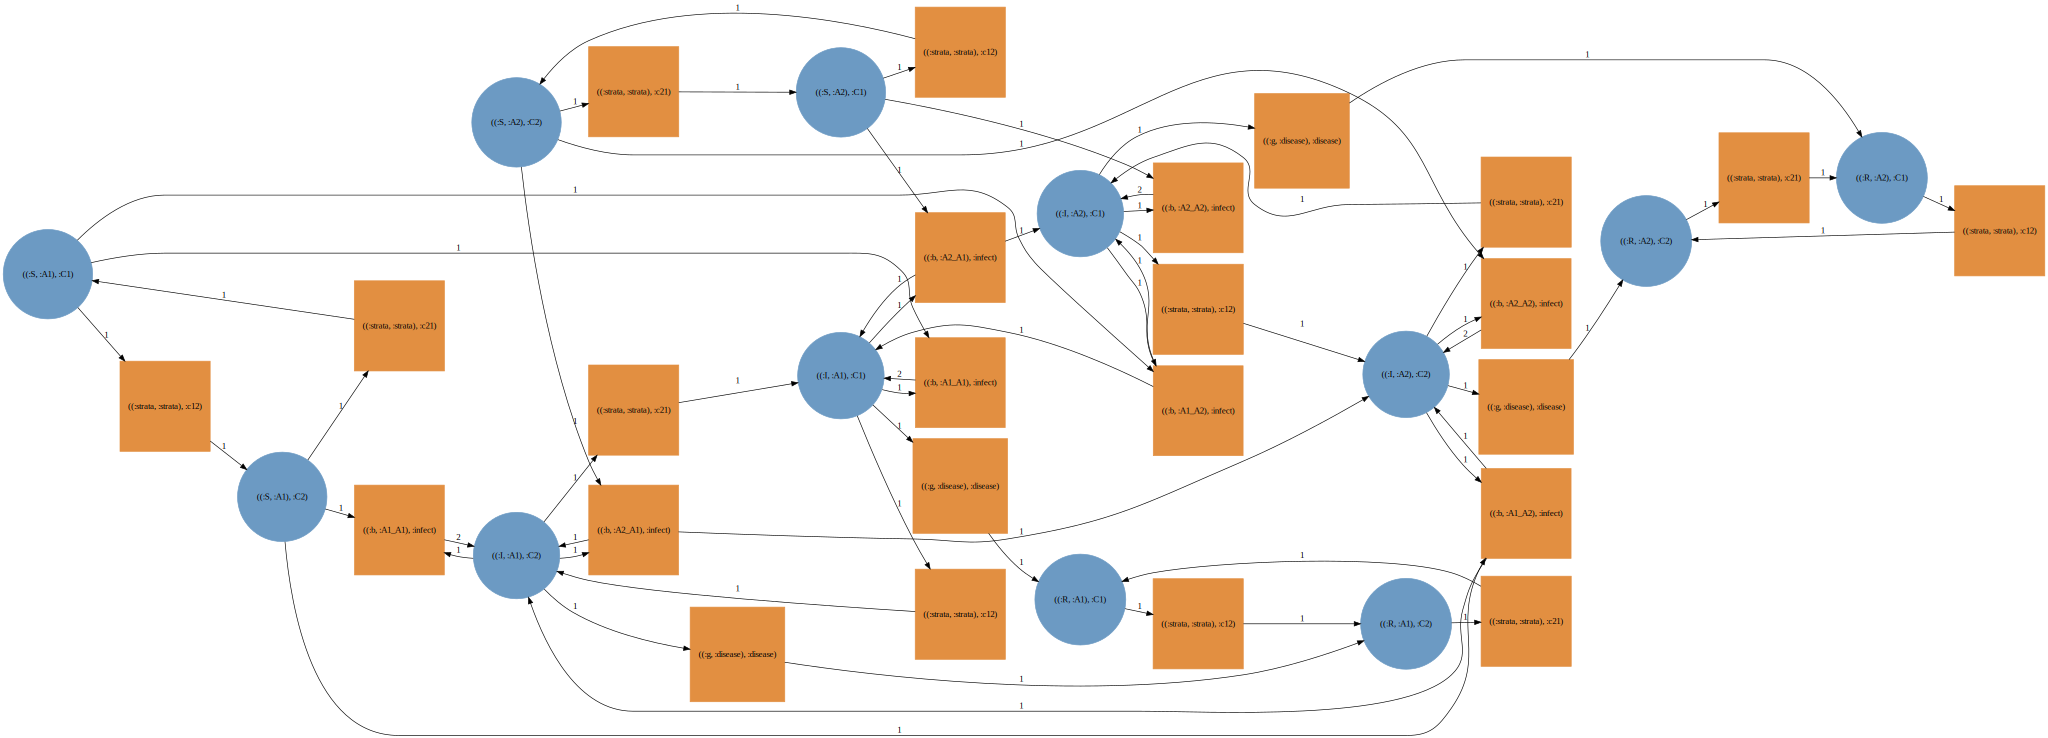

In [55]:
typed_sir_age_travel = typed_product(typed_sir_age, typed_travel_aug)

Graph(dom(typed_sir_age_travel))

In [56]:
# Save to file
write_json_acset(dom(typed_sir_age_travel), "model_petri_sir-age-travel.json")

2335

## Additional Models for Reference

### Quarantine Model

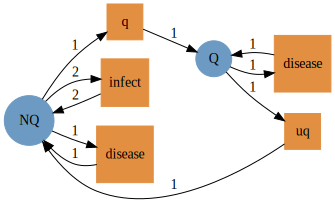

In [58]:
# Define the UWD
quarantine_uwd = @relation () where (NQ::Pop, Q::Pop) begin
    strata(NQ, Q)
    strata(Q, NQ)
end

to_graphviz(quarantine_uwd, box_labels = :name, junction_labels = :variable)

tnames = [:q, :uq]
typed_quarantine = oapply_typed(infectious_ontology, quarantine_uwd, tnames)
Graph(dom(typed_quarantine))


# Augment the model to enable SIR interactions (S <-> I, I -> R)
typed_quarantine_aug = add_reflexives(
    typed_quarantine,
    [[:infect, :disease], [:disease]],
    infectious_ontology
)

Graph(dom(typed_quarantine_aug))

### Vaccination Model

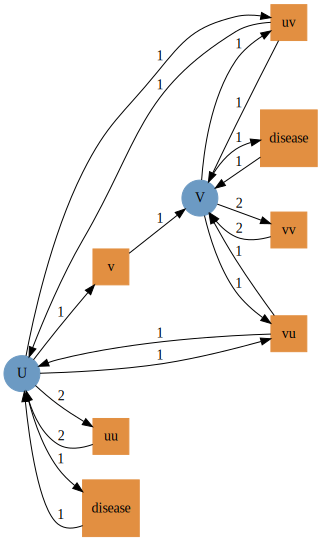

In [59]:
# Define the UWD
vaccination_uwd = @relation () where (U::Pop, V::Pop) begin
    strata(U,V) # vaccination
    infect(U,U,U,U) # (U, U) -> (U, U)
    infect(U,V,U,V) # (U, V) -> (U, V)
    infect(V,U,V,U) # (V, U) -> (V, U)
    infect(V,V,V,V) # (V, V) -> (V, V)
end

to_graphviz(vaccination_uwd, box_labels = :name, junction_labels = :variable)

tnames = [:v, :uu, :uv, :vu, :vv]
typed_vaccination = oapply_typed(infectious_ontology, vaccination_uwd, tnames)
Graph(dom(typed_vaccination))


# Augment quarantine model to enable disease-type interaction (I -> R)
typed_vaccination_aug = add_reflexives(
    typed_vaccination,
    [[:disease], [:disease]],
    infectious_ontology
)

Graph(dom(typed_vaccination_aug))